# Predicting Fold-State of Proteins 
### Lucas Ramadan 
-------

### Abstract
> Given a sequence of amino acids, making up a protein, can we predict the structure? For each amino acid, there is a corresponding "fold-state" which we would like to infer. I first benchmark the analysis with a simple 3-layer Feed-Forward Neural Network. I then add a convolutional layer, which seems to improve the prediction. A GRU layer is then added, which also improves the accuracy. Finally, I present future work, which includes implementing Batch Normalization, which will likely help overcome some of the challenges of this data. 

In [46]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

/Users/LucasRamadan/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Why do we care about modeling fold state?

<img  src="imgs/drug_design.png"/>

### What a protein looks like:

<img  src="imgs/protein_ex.jpg"/>

In [2]:
seq = pd.read_csv('sequences.csv').drop('Unnamed: 0', axis=1).values.reshape((-1,))

IOError: File sequences.csv does not exist

### How the protein is encoded for us:

<img  src="imgs/AA_code.png" height=400 width=400/>

<img  src="imgs/protein_seq.jpg"/>

### What our actual data looks like:

In [15]:
print seq[:100]

['V' 'L' 'S' 'P' 'A' 'D' 'K' 'T' 'N' 'V' 'K' 'A' 'A' 'W' 'G' 'K' 'V' 'G'
 'A' 'H' 'A' 'G' 'E' 'Y' 'G' 'A' 'E' 'A' 'L' 'E' 'R' 'M' 'F' 'L' 'S' 'F'
 'P' 'T' 'T' 'K' 'T' 'Y' 'F' 'P' 'H' 'F' 'D' 'L' 'S' 'H' 'G' 'S' 'A' 'Q'
 'V' 'K' 'G' 'H' 'G' 'K' 'K' 'V' 'A' 'D' 'A' 'L' 'T' 'N' 'A' 'V' 'A' 'H'
 'V' 'D' 'D' 'M' 'P' 'N' 'A' 'L' 'S' 'A' 'L' 'S' 'D' 'L' 'H' 'A' 'H' 'K'
 'L' 'R' 'V' 'D' 'P' 'V' 'N' 'F' 'K' 'L']


### How this relates to Structure

<img  src="imgs/seq_structure.png"/>

<img  src="imgs/protein_structure.jpg"/>

### Fold States:

In [135]:
labels = pd.read_csv('5_formatted_labels.csv').drop('Unnamed: 0', axis=1).values.reshape((-1,))

In [137]:
fold_map = dict(zip(range(6), ["H", "E", "T", "S", "B", "U"]))

In [138]:
folds = np.asarray([fold_map[state] for state in labels])

In [139]:
print folds[:100]

['U' 'U' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'
 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'U' 'H'
 'H' 'H' 'H' 'H' 'H' 'U' 'T' 'T' 'S' 'U' 'U' 'S' 'T' 'T' 'U' 'H' 'H' 'H'
 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'T' 'T'
 'T' 'S' 'H' 'H' 'H' 'H' 'T' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'T' 'T'
 'U' 'U' 'U' 'T' 'H' 'H' 'H' 'H' 'H' 'H']


### Together

In [61]:
pd.DataFrame([folds[:100], seq[:100]], index=['Fold', 'AA'], columns=['']*100)

,,,,,,,,,,,...,,,,,,,,,,
Fold,U,U,H,H,H,H,H,H,H,H,...,U,U,U,T,H,H,H,H,H,H
AA,V,L,S,P,A,D,K,T,N,V,...,L,R,V,D,P,V,N,F,K,L


In [56]:
counts = Counter(folds)
percents = [v*1.0 / sum(counts.values()) for v in counts.values()]

perc = dict(zip(counts.keys(), percents))

### Imbalanced Classes

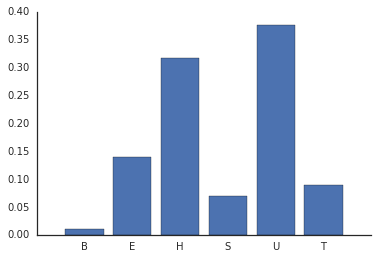

In [57]:
plt.bar(range(len(perc)), perc.values(), tick_label=perc.keys(), align='center')
sns.set_style('white')
sns.despine();

### Recall:

<img  src="imgs/cbow.png" height=400 width=400/>

### How our data is really formatted

In [63]:
skip_data = pd.read_csv('5_formatted_fixed.csv').drop('Unnamed: 0', axis=1)
skip_data.head()

,A-2,C-2,D-2,E-2,F-2,G-2,H-2,I-2,K-2,L-2,...,N2,P2,Q2,R2,S2,T2,V2,W2,Y2,-2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Take for an example:

In [65]:
print seq[:5]

['V' 'L' 'S' 'P' 'A']


In [68]:
['V-2', 'L-1', 'S0', 'P1', 'A2']

['V-2', 'L-1', 'S0', 'P1', 'A2']

In [108]:
ex0 = skip_data.ix[2]
pd.DataFrame([ex0.index, ex0.values], index=['AA', ''], columns=['']*105)

,,,,,,,,,,,...,,,,,,,,,,
AA,A-2,C-2,D-2,E-2,F-2,G-2,H-2,I-2,K-2,L-2,...,N2,P2,Q2,R2,S2,T2,V2,W2,Y2,-2
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Running through Dimensionality 

In [248]:
import theano
from theano import tensor as T
import numpy as np
from theano.tensor.nnet.conv import conv2d

In [253]:
# generating some fake data labels
Y_ex = np.zeros((128, 6))

for i, r in enumerate(Y_ex):
    r[np.random.randint(6)] = 1
    Y_ex[i] = r

In [250]:
mbs = 128 # mini-batch size
n_channels, n_rows, n_cols = 1, 5, 21 # define protein "image" dimensions
n_conv = 256 # features out of convolution
h_depth = 50 # hidden layer depth
o_depth = 6 # output depth

In [252]:
X = theano.shared(np.array(xrange(mbs*n_channels*n_rows*n_cols), 
                           dtype=theano.config.floatX).reshape((mbs, n_channels, n_rows, n_cols)))

wc = theano.shared(np.array(xrange(n_conv*n_channels*n_rows*n_cols), 
                            dtype=theano.config.floatX)).reshape((n_conv, n_channels, n_rows, n_cols))

wh = theano.shared(np.array(xrange(n_conv*h_depth), dtype=theano.config.floatX)).reshape((n_conv, h_depth))

wh2 = theano.shared(np.array(xrange(h_depth*h_depth), dtype=theano.config.floatX)).reshape((h_depth, h_depth))

wy = theano.shared(np.array(xrange(h_depth*o_depth), dtype=theano.config.floatX)).reshape((h_depth, o_depth))

Y = theano.shared(Y_ex)

print 'X:', X.eval().shape
print 'Conv:', wc.eval().shape
convOut = conv2d(X, wc, border_mode='valid')  #border_mode={'valid', 'full'}

convOut = convOut.reshape((-1, n_conv))
print '-'*40
print 'ConvOut:', convOut.eval().shape
print 'wh1:', wh.eval().shape

hiddenOut1 = T.dot(convOut, wh)
print '-'*40
print 'Hidden1Out:', hiddenOut1.eval().shape
print 'wh2:', wh2.eval().shape
hiddenOut2 = T.dot(hiddenOut1, wh2)

print '-'*40
print 'Hidden2Out:', hiddenOut2.eval().shape

yOut = T.dot(hiddenOut2, wy)

print 'wy:', wy.eval().shape
print '-'*40
print 'yOut:', yOut.eval().shape
print '-'*40
smax_out = T.nnet.softmax(yOut)

test = smax_out.eval()
print 'ex:'
print test[:10]
print 'truth:'
print Y.eval()[:10]
print '-'*40
print 'preds:', test.shape
print 'true:', Y.eval().shape
print '-'*40
print 'mean:', T.mean(((Y.eval() - test)**2)).eval()

X: (128, 1, 5, 21)
Conv: (256, 1, 5, 21)
----------------------------------------
ConvOut: (128, 256)
wh1: (256, 50)
----------------------------------------
Hidden1Out: (128, 50)
wh2: (50, 50)
----------------------------------------
Hidden2Out: (128, 50)
wy: (50, 6)
----------------------------------------
yOut: (128, 6)
----------------------------------------
ex:
[[ 0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.]]
truth:
[[ 0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]]
----------------------------------------
preds: (128, 6)
true: (128, 6)
---------

# Simple Feed Forward Neural Network:

In [110]:
import theano
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

from sklearn.cross_validation import train_test_split
from math import sqrt

In [152]:
data = pd.read_csv('5_formatted_fixed.csv').drop('Unnamed: 0', axis=1)
labels = pd.read_csv('5_formatted_fixed_labels.csv').drop('Unnamed: 0', axis=1)
print data.shape, labels.shape

(134815, 105) (134815, 6)


In [153]:
xTrain, xTest, yTrain, yTest = train_test_split(np.asarray(data), np.asarray(labels))
print xTrain.shape, yTrain.shape, xTest.shape, yTest.shape

(101111, 105) (101111, 6) (33704, 105) (33704, 6)


In [159]:
def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def init_weights(shape):
    (h, w) = shape
    normalizer = 2.0 * sqrt(6) / sqrt(h + w) * 0.1  #factors: correct for uni[0,1], glo, glo, softmax deriv
    return theano.shared(floatX((np.random.random_sample(shape) - 0.5) * normalizer))  #code for using Glorot init

def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

def model(X, w_h, w_o):
    h = T.nnet.sigmoid(T.dot(X, w_h))
    pyx = T.nnet.softmax(T.dot(h, w_o))
    return pyx

X = T.fmatrix()
Y = T.fmatrix()

w_h = init_weights((105, 600))
w_o = init_weights((600, 6))

py_x = model(X, w_h, w_o)
y_pred = T.argmax(py_x, axis=1)

cost = T.mean(T.nnet.categorical_crossentropy(py_x, Y))
params = [w_h, w_o]

update = RMSprop(cost, params, lr=0.005)

train = theano.function(inputs=[X, Y], outputs=cost, updates=update, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_pred, allow_input_downcast=True)

costs = []
train_scores = []
test_scores = []

for i in range(501):
    for start, end in zip(range(0, len(xTrain), 128), range(128, len(xTrain), 128)):
        cost = train(xTrain[start:end], yTrain[start:end])
    
    costs.append(cost)
    
    train_acc = np.mean(np.argmax(yTrain, axis=1) == predict(xTrain))
    
    test_acc = np.mean(np.argmax(yTest, axis=1) == predict(xTest))
    
    test_scores.append(test_acc)
    train_scores.append(train_acc)
    
    print i, train_acc, test_acc

0 0.460573033597 0.462467362924
1 0.478038986856 0.480239734156
2 0.485960973583 0.487835271778
3 0.498096151754 0.500029670069
4 0.545885215258 0.548480892476
5 0.556586325919 0.557826964159
6 0.559256658524 0.559963209115
7 0.565952270277 0.564947780679
8 0.572499530219 0.571564206029
9 0.577048985768 0.576430097318
10 0.581143495762 0.580079515784
11 0.583873169091 0.583372893425
12 0.586187457349 0.58631023024
13 0.590034714324 0.589336577261
14 0.594000652748 0.593193686209
15 0.598965493369 0.595359601234
16 0.602970992276 0.599187040114
17 0.605730335967 0.601798006171
18 0.608885284489 0.604408972229
19 0.610932539486 0.606604557323
20 0.614413861993 0.60820674104
21 0.617479799428 0.610194635652
22 0.619358922372 0.611055067648
23 0.621584199543 0.612597911227
24 0.623601784178 0.614200094944
25 0.62597541316 0.615179207216
26 0.627666623809 0.615772608592
27 0.629585307237 0.61737479231
28 0.631503990664 0.618175884168
29 0.6338083888 0.618976976027
30 0.636290809111 0.619362

KeyboardInterrupt: 

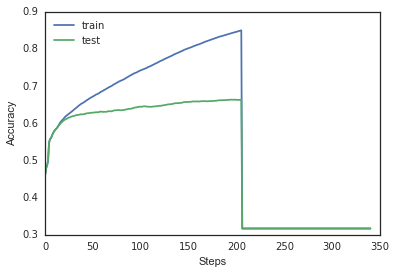

In [160]:
plt.plot(train_scores, label='train')
plt.plot(test_scores, label='test')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend(loc=2);

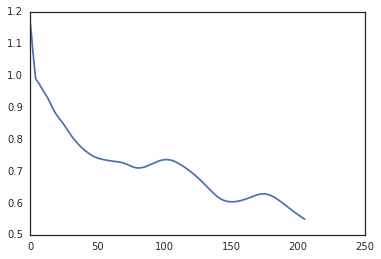

In [161]:
plt.plot(costs);

### It took me a while to realize, but what seems to be happening is that the weights are going to zero. In this case, all of our predictions are going to be for class zero. Class zero corresponds to fold state H. Due to the class imbalance, the p(H) is this ~32% accuracy, which explains the constant accuracy score. 

### Thus, the Gradients must be vanishing

## Adding convolution complexity

#### Returning to our example

In [186]:
print seq[0:5]

['V' 'L' 'S' 'P' 'A']


In [178]:
['V-2', 'L-1', 'S0', 'P1', 'A2']

['V-2', 'L-1', 'S0', 'P1', 'A2']

In [179]:
ex0 = skip_data.ix[2]
pd.DataFrame([ex0.index, ex0.values], index=['AA', ''], columns=['']*105)

,,,,,,,,,,,...,,,,,,,,,,
AA,A-2,C-2,D-2,E-2,F-2,G-2,H-2,I-2,K-2,L-2,...,N2,P2,Q2,R2,S2,T2,V2,W2,Y2,-2
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [187]:
# read our data in 

aminos = ['-','A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
positions = sorted(map(str, range(-(n_window-1)//2, (n_window+1)//2, 1)))

n_window = 13
n_aminos = 21

loaded_data = get_data_tensor(n = n_window)
    
labels = pd.read_csv('one_hot_labels.csv')

# We reformat each protein context into an "image" 

In [ ]:
    -  A  C  D  E  F  G  H  I  K  L  M  N  P  Q  R  S  T  V  W  Y
-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
-2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0   0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
1   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
2   0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0

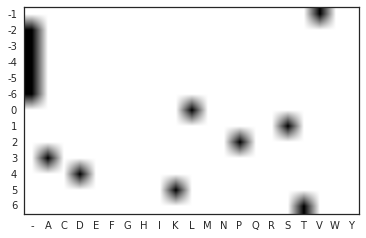

In [194]:
plt.imshow(loaded_data[:1].reshape((13, 21)));
plt.xticks(xrange(len(aminos)), aminos)
plt.yticks(xrange(len(positions)), positions);

# Now Build the Convolutional Network

In [199]:
# theano imports
import theano
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.nnet.conv import conv2d
# from theano.tensor.signal.downsample import max_pool_2d
from theano.tensor.signal.pool import pool_2d as max_pool_2d
from theano.tensor.nnet import batch_normalization

# other imports
from sklearn.cross_validation import train_test_split
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

## Here we will apply a series of convolutional filters (256) to the amino image, and receive a scalar representing the Amino Acid and its context

<img  src="imgs/conv_Filter.png"/>

In [210]:
# helper function for loading in data of a specific encoding window
def get_data_tensor(n = 5):
    filename = 'conv_data/' + str(n) + '_tensor.p'
    
    with open(filename, 'rb') as f:
        loaded_data = pickle.load(f)
    
    return loaded_data

In [211]:
# read our data in 

n_window = 13
n_aminos = 21

loaded_data = get_data_tensor(n = n_window)
    
labels = pd.read_csv('one_hot_labels.csv')

In [212]:
one_hot = labels.values

xTrain, xTest, yTrain, yTest = train_test_split(loaded_data, one_hot)
xTrain = xTrain.reshape(-1, 1, n_window, n_aminos)
xTest = xTest.reshape(-1, 1, n_window, n_aminos)

print xTrain.shape, xTest.shape, yTrain.shape, yTest.shape

(101110, 1, 13, 21) (33704, 1, 13, 21) (101110, 6) (33704, 6)


In [213]:
srng = RandomStreams()

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def glorot_init_weights(shape):
    (h, w) = shape
    # 0.25 for sigmoid, 0.1 for softmax, 1.0 for tanh/relu
    normalizer = 2.0 * (6**0.5) / ((h + w)**0.5) * 1.0  #factors: 0.1 correct for uni[0,1], glo, glo, softmax deriv
    return theano.shared(floatX((np.random.random_sample(shape) - 0.5) * normalizer))

def init_weights(shape):
    return theano.shared(floatX(np.random.randn(*shape) * 0.01))

def activate(X):
    return T.nnet.relu(X)

def rectify(X):
#     return T.maximum(X, 0.)
    return T.maximum(X, 0.01*X)  #leaky rectifier

def ELU(X, alpha=0.1):
    return T.switch(X > 0, X, alpha * (T.exp(X) - 1))
    
def softmax(X):
    e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 1, 'x', 'x'))
    return e_x / e_x.sum(axis=1).dimshuffle(0, 1, 'x', 'x')

def dropout(X, p=0.0):
    if p > 0:
        retain_prob = 1 - p
        X *= srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX)
        X /= retain_prob
    return X

def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    
    return updates

def model(X, wi, wh, bh, wo, bo, p_drop_conv, p_drop_hidden):
    
    # --------------------------------------------
    
    layer_1 = conv2d(X, wi, border_mode='valid')
    layer_1 = layer_1.reshape((-1, 256))
    layer_1 = ELU(layer_1)
    layer_1 = dropout(layer_1, p_drop_conv)

    # --------------------------------------------
    
    layer_2 = T.dot(layer_1, wh) + bh    
    layer_2 = ELU(layer_2)
    layer_2 = dropout(layer_2, p_drop_hidden)
    
    # --------------------------------------------
    
    layer_3 = T.dot(layer_2, wo) + bo
    layer_3 = dropout(layer_3, p_drop_hidden)
    
    # --------------------------------------------
    
#     pyx = softmax(layer_3)
    pyx = T.nnet.softmax(layer_3)
    return layer_1, layer_2, layer_3, pyx

In [216]:
X = T.ftensor4()
Y = T.fmatrix()

# define number of desired features out of convolution
n_conv = 256

# define hidden layer depth
h_depth = 50

# define output layer size
o_depth = 6

# ----------------------------- FOR WITHOUT BATCH NORMALIZATION------------------------------

# input parameters
wi = init_weights((n_conv, 1, n_window, n_aminos))

# hidden parameters
wh = glorot_init_weights((n_conv, h_depth))
bh = theano.shared(floatX(np.zeros(h_depth)))

# output parameters
wo = glorot_init_weights((h_depth, o_depth))
bo = theano.shared(floatX(np.zeros(o_depth)))

# modeling and parameters for Gradient Descent
params = [wi, wh, bh, wo, bo]
noise_l1, noise_l2, noise_l3, noise_py_x = model(X, wi, wh, bh, wo, bo, 0.2, 0.5)
l1, l2, l3, py_x = model(X, wi, wh, bh, wo, bo, 0., 0.)

# -------------------------------------------------------------------------------------------

y_x = T.argmax(py_x, axis=1)
cost = T.mean(T.nnet.categorical_crossentropy(noise_py_x, Y))
updates = RMSprop(cost, params, lr=1e-4) 

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

In [217]:
# number of training iterations to perform
n_train = 31

# define mini-batch size
mbs = 128

# store our results
costs = []
test_scores = []
train_scores = []

# performing our training
for i in xrange(n_train):
    
    for start, end in zip(xrange(0, len(xTrain), mbs), 
                          xrange(mbs, len(xTrain), mbs)):
    
        cost = train(xTrain[start:end], yTrain[start:end])
    
    costs.append(cost)
    
    train_score = np.mean(np.argmax(yTrain, axis=1) == predict(xTrain)) 
    test_score = np.mean(np.argmax(yTest, axis=1) == predict(xTest))
    
    test_scores.append(test_score)
    train_scores.append(train_score)
    
    print 'iteration:', i, '-------', 'train:', round(train_score, 3), '-------', 'test:', round(test_score, 3)
    print '1st filter:', wi.eval()[0][0][0][:5] # take a quick look at conv filter
    print '-'*60
    
# got up to about 67% w/ 5 vectors!
# up to like 69% with a 9 vector

iteration: 0 ------- train: 0.616 ------- test: 0.612
1st filter: [ 0.00399164  0.00790589  0.00421786  0.00330725 -0.00131144]
------------------------------------------------------------
iteration: 1 ------- train: 0.626 ------- test: 0.622
1st filter: [ 0.00061803  0.00970135  0.00475286  0.00108363 -0.0030484 ]
------------------------------------------------------------
iteration: 2 ------- train: 0.63 ------- test: 0.624
1st filter: [ 0.00138729  0.01095211  0.00632949  0.00159674 -0.00227471]
------------------------------------------------------------
iteration: 3 ------- train: 0.63 ------- test: 0.625
1st filter: [-0.00113194  0.01244355  0.00889163  0.00013126 -0.00151669]
------------------------------------------------------------
iteration: 4 ------- train: 0.632 ------- test: 0.626
1st filter: [-0.00573713  0.01322613  0.00944777  0.00273066 -0.00183793]
------------------------------------------------------------
iteration: 5 ------- train: 0.631 ------- test: 0.626
1st

### How we are doing:

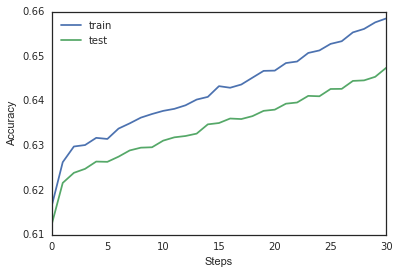

In [218]:
# plot our accuracies
plt.plot(xrange(n_train), train_scores, label='train')
plt.plot(xrange(n_train), test_scores, label='test')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend(loc=2);

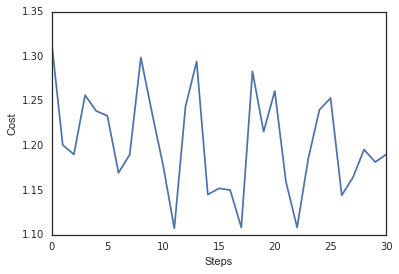

In [219]:
# plot our cost
plt.plot(xrange(n_train), costs)
plt.xlabel('Steps')
plt.ylabel('Cost');

### Taking a look at the Convolutional Filters (Amino Maps)

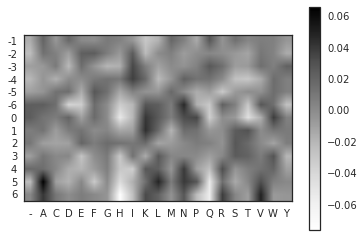

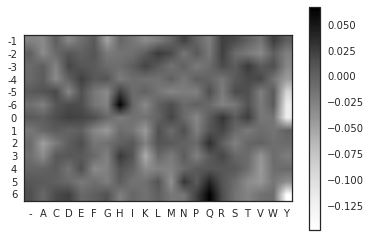

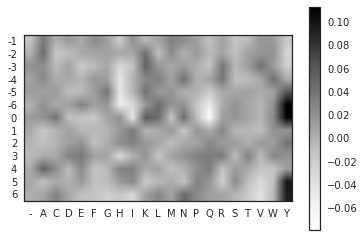

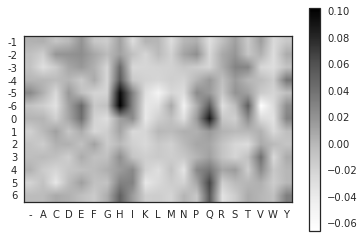

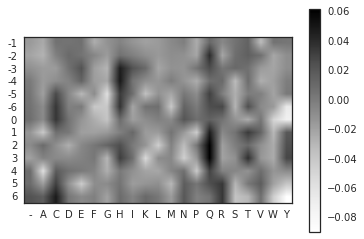

In [220]:
# AMINO MAPS (n_window, 21)
aminos = ['-','A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
# positions = ['-1', '-2', '0', '1', '2']

positions = sorted(map(str, range(-(n_window-1)//2, (n_window+1)//2, 1)))

for conv in wi.eval()[:5]:
    c = conv.reshape(n_window, n_aminos)
    plt.imshow(c, cmap='Greys')
    plt.xticks(range(len(aminos)), aminos)
    plt.yticks(range(len(positions)), positions)
    plt.colorbar()
    plt.show()

## Batch Normalization

In [228]:
# hoping to get batch normalization implemented below
# data, input weights, gamma input, beta input, hidden weights, hidden bias, gamma hidden, beta hidden, 
# output weights, output bias, gamma output, beta output, p_drop, p_hidden_drop
def model_bn(X, wi, gi, bbi, wh, bh, gh, bbh, wo, bo, go, bbo, p_drop_conv, p_drop_hidden):

    # --------------------------------------------
    
    layer_1 = conv2d(X, wi, border_mode='valid')
    layer_1 = layer_1.reshape((-1, 256))
    layer_1 = batch_normalization(layer_1, gamma=gi, beta=bbi, 
                                 mean=layer_1.mean((0, ), keepdims=True), 
                                  std = T.ones_like(layer_1.var((0,), keepdims=True)), 
                                  mode='high_mem')

    layer_1 = ELU(layer_1)
    layer_1 = dropout(layer_1, p_drop_conv)


    # --------------------------------------------
    
    layer_2 = T.dot(layer_1, wh) + bh
#     layer_2 = batch_normalization(layer_2, gamma=gh, beta=bbh, 
#                                  mean=X.mean((0, ), keepdims=True), 
#                                   std = T.ones_like(layer_2.var((0,), keepdims=True)), 
#                                   mode='high_mem')
    
    layer_2 = ELU(layer_2)
    layer_2 = dropout(layer_2, p_drop_hidden)
    
    # --------------------------------------------
    
    layer_3 = T.dot(layer_2, wo) + bo
#     layer_3 = batch_normalization(layer_3, gamma=go, beta=bbo, 
#                                  mean=X.mean((0, ), keepdims=True), 
#                                   std = T.ones_like(layer_3.var((0,), keepdims=True)), 
#                                   mode='high_mem')
    
    layer_3 = dropout(layer_3, p_drop_hidden)
    
    # --------------------------------------------
    
    # thinks it's getting a 4D Tensor ???
#     pyx = softmax(layer_3)
    pyx = T.nnet.softmax(layer_3)
    return layer_1, layer_2, layer_3, pyx

In [229]:
X = T.ftensor4()
Y = T.fmatrix()

# define number of desired features out of convolution
n_conv = 256

# define hidden layer depth
h_depth = 50

# define output layer size
o_depth = 6

# --------------------------- FOR BATCH NORMALIZATION -----------------------

# initialize weight matrices: wi, gi, bbi, wh, bh, gh, bbh, wo, bo, go, bbo

# input parameters
wi = init_weights((n_conv, 1, n_window, n_aminos))
gi = theano.shared(floatX(np.ones(n_conv)))
bbi = theano.shared(floatX(np.zeros(n_conv)))

# hidden parameters
wh = glorot_init_weights((n_conv, h_depth))
bh = theano.shared(floatX(np.zeros(h_depth)))
gh = theano.shared(floatX(np.ones(h_depth)))
bbh = theano.shared(floatX(np.zeros(h_depth)))

# output parameters
wo = glorot_init_weights((h_depth, o_depth))
bo = theano.shared(floatX(np.zeros(o_depth)))
go = theano.shared(floatX(np.ones(o_depth)))
bbo = theano.shared(floatX(np.zeros(o_depth)))

# modeling and parameters for Gradient Descent
noise_l1, noise_l2, noise_l3, noise_py_x = model_bn(X, wi, gi, bbi, wh, bh, gh, bbh, wo, bo, go, bbo, 0.2, 0.5)
l1, l2, l3, py_x = model_bn(X, wi, gi, bbi, wh, bh, gh, bbh, wo, bo, go, bbo, 0., 0.)
params = [wi, gi, bbi, wh, bh, wo, bo]
# params = [wi, gi, bbi, wh, bh, gh, bbh, wo, bo, go, bbo]

# output and training 

y_x = T.argmax(py_x, axis=1)
cost = T.mean(T.nnet.categorical_crossentropy(noise_py_x, Y))
updates = RMSprop(cost, params, lr=1e-4) #lr=1e-7 <--- way too small of a LR

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

In [230]:
# number of training iterations to perform
n_train = 31

# define mini-batch size
mbs = 128

# store our results
costs = []
test_scores = []
train_scores = []

# performing our training
for i in xrange(n_train):
    
    for start, end in zip(xrange(0, len(xTrain), mbs), 
                          xrange(mbs, len(xTrain), mbs)):
    
        cost = train(xTrain[start:end], yTrain[start:end])
    
    costs.append(cost)
    
    train_score = np.mean(np.argmax(yTrain, axis=1) == predict(xTrain)) 
    test_score = np.mean(np.argmax(yTest, axis=1) == predict(xTest))
    
    test_scores.append(test_score)
    train_scores.append(train_score)
    
    print 'iteration:', i, '-------', 'train:', round(train_score, 3), '-------', 'test:', round(test_score, 3)
    print wi.eval()[0][0][0][:5] # take a quick look at conv filter
    print '-'*60
    
# got up to about 67% w/ 5 vectors!
# up to like 69% with a 9 vector

iteration: 0 ------- train: 0.614 ------- test: 0.608
[ 0.00593788 -0.00019477 -0.0006099  -0.00062671  0.00380522]
------------------------------------------------------------
iteration: 1 ------- train: 0.626 ------- test: 0.619
[ 0.00765749 -0.0013383   0.00097921 -0.00123534 -0.00088002]
------------------------------------------------------------
iteration: 2 ------- train: 0.629 ------- test: 0.623
[ 0.00876028  0.00023676 -0.00368068 -0.00249916 -0.00253745]
------------------------------------------------------------
iteration: 3 ------- train: 0.632 ------- test: 0.625
[ 0.00724359 -0.00341226 -0.00226375 -0.00549094 -0.00479607]
------------------------------------------------------------
iteration: 4 ------- train: 0.632 ------- test: 0.627
[ 0.00439669 -0.00547707 -0.00344816 -0.00820479 -0.00509839]
------------------------------------------------------------
iteration: 5 ------- train: 0.632 ------- test: 0.627
[ 0.00408968 -0.00919535 -0.00507226 -0.00964145 -0.00349244]

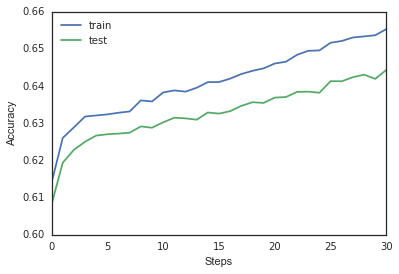

In [231]:
# plot our accuracies
plt.plot(xrange(n_train), train_scores, label='train')
plt.plot(xrange(n_train), test_scores, label='test')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend(loc=2);

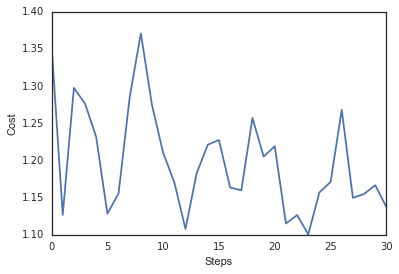

In [232]:
# plot our cost
plt.plot(xrange(n_train), costs)
plt.xlabel('Steps')
plt.ylabel('Cost');

## Now Added GRU between Convolutional Layer and Feed Foward

Input --Conv--> ConvOut --GRU--> GRUOut

In [239]:
srng = RandomStreams()

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def glorot_init_weights(shape):
    (h, w) = shape
    normalizer = 2.0 * (6**0.5) / ((h + w)**0.5) * 0.1  #factors: correct for uni[0,1], glo, glo, softmax deriv
    return theano.shared(floatX((np.random.random_sample(shape) - 0.5) * normalizer))

def init_weights(shape):
    return theano.shared(floatX(np.random.randn(*shape) * 0.01))

def activ(x, f=None):
    if f == 'tan':
        return T.tanh(x)
    else:
        return T.nnet.sigmoid(x)

def ELU(X, alpha=0.1):
    return T.switch(X > 0, X, alpha * (T.exp(X) - 1))
    
def dropout(X, p=0.0):
    if p > 0:
        retain_prob = 1 - p
        X *= srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX)
        X /= retain_prob
    return X
    
def RMSprop(cost, params, lr=1e-3, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    
    return updates

def conv_model(X, wc, wh=None, p_drop_conv=0.0, p_drop_hidden=0.0):
    l_1 = ELU(conv2d(X, wc, border_mode='valid'))
    l_1 = l_1.reshape((-1, 256))
#     l_1 = dropout(l_1, p_drop_conv)

#     l_2 = rectify(T.dot(layer_1, wh))
#     l_2 = dropout(layer_2, p_drop_hidden)
    
    return l_1

In [240]:
X = T.ftensor4()# dims (mbs, n_channels, n_rows, n_cols)
Y = T.fmatrix() # dims (mbs, o_depth)

n_channels, n_rows, n_cols = 1, n_window, 21 # define protein "image" dimensions
n_conv = 256 # features out of convolution
h_depth = 50 # hidden layer depth
o_depth = 6 # output depth

# initialize weights for conv layer
W_c = init_weights((n_conv, n_channels, n_rows, n_cols))

# initial weight matrices
W_uh = np.asarray(np.random.randn(n_conv, h_depth) * 0.001, dtype = theano.config.floatX)
W_hh = np.asarray(np.random.randn(h_depth, h_depth) * 0.001, dtype = theano.config.floatX)
W_hy = np.asarray(np.random.randn(h_depth, o_depth) * 0.001, dtype = theano.config.floatX)
b_hh = np.zeros(h_depth, dtype=theano.config.floatX)
b_hy = np.zeros(o_depth, dtype=theano.config.floatX)

W_uh = theano.shared(W_uh, 'W_uh')
W_hh = theano.shared(W_hh, 'W_hh')
W_hy = theano.shared(W_hy, 'W_hy')
b_hh = theano.shared(b_hh, 'b_hh')
b_hy = theano.shared(b_hy, 'b_hy')

# define new matrices 
Wr_uh = np.asarray(np.random.randn(n_conv, h_depth) * 0.001, dtype = theano.config.floatX)
Wr_hh = np.asarray(np.random.randn(h_depth, h_depth) * 0.001, dtype = theano.config.floatX)
Wz_uh = np.asarray(np.random.randn(n_conv, h_depth) * 0.001, dtype = theano.config.floatX)
Wz_hh = np.asarray(np.random.randn(h_depth, h_depth) * 0.001, dtype = theano.config.floatX)

Wr_uh = theano.shared(Wr_uh, 'Wr_uh')
Wr_hh = theano.shared(Wr_hh, 'Wr_hh')
Wz_uh = theano.shared(Wz_uh, 'Wz_uh')
Wz_hh = theano.shared(Wz_hh, 'Wz_hh')

h0_tm1 = theano.shared(np.zeros(h_depth, dtype=theano.config.floatX))

# have conv_model outside of recurrent fn
u = conv_model(X, W_c)

params = [W_c, W_hh, W_uh, W_hy, Wr_uh, Wr_hh, Wz_uh, Wz_hh, b_hh, b_hy]

def recurrent_fn(u_t, h_tm1, W_hh, W_uh, W_hy, Wr_uh, Wr_hh, Wz_uh, Wz_hh, b_hh, b_hy):
    
    r_t = activ(T.dot(u_t, Wr_uh) + T.dot(h_tm1, Wr_hh))
    z_t = activ(T.dot(u_t, Wz_uh) + T.dot(h_tm1, Wz_hh))
    
    h_tilda = activ(T.dot(u_t, W_uh) + r_t*T.dot(h_tm1, W_hh), f='tan')
    
    h_t = ((1 - z_t)*h_tm1) + (z_t*h_tilda) + b_hh
    
    # adding in softmax, for one hot coding 
    y_t = T.nnet.softmax(T.dot(h_t, W_hy) + b_hy)
    
    return h_t, y_t

[h, y], _ = theano.scan(recurrent_fn, 
                       sequences = u,
                       outputs_info = [h0_tm1, None],
                       non_sequences = [W_hh, W_uh, W_hy, Wr_uh, Wr_hh, Wz_uh, Wz_hh, b_hh, b_hy])

y = y.reshape((-1, 6))

# for some reason, y is a (128, 128, 6) tensor ? ---- had to do with the h @ t-1

cost = T.mean((Y - y)**2)
# cost = T.mean(T.nnet.categorical_crossentropy(y, Y))

update = RMSprop(cost, params) #lr=1e-7

y_x = T.argmax(y, axis=1)

train = theano.function(inputs=[X, Y], outputs=[cost, y], updates=update, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

In [241]:
# number of training iterations to perform
n_train = 31

# mini-batch size --- MUCH improved from previous 128
mbs = 3 

costs = []
train_scores = []
test_scores = []

# performing our training
for i in xrange(n_train):
    for start, end in zip(xrange(0, len(xTrain), mbs), 
                          xrange(mbs, len(xTrain), mbs)):
        cost, yi = train(xTrain[start:end], yTrain[start:end])
#         print i, 'training:', np.mean(np.argmax(yTrain, axis=1) == predict(xTrain))
#         print i, 'test:', np.mean(np.argmax(yTest, axis=1) == predict(xTest))
#         print '-'*50
    train_score = np.mean(np.argmax(yTrain, axis=1) == predict(xTrain))
    train_scores.append(train_score)
    test_score = np.mean(np.argmax(yTest, axis=1) == predict(xTest))
    test_scores.append(test_score)
    print 'iteration:', i, '-------', 'train:', round(train_score, 3), '-------', 'test:', round(test_score, 3)
    print 'cost:', cost
    print 'yi:', yi[0]
    print 'wc:', wi.eval()[0][0][0][:5]
    print '-'*50
    costs.append(cost)

iteration: 0 ------- train: 0.644 ------- test: 0.636
cost: 0.0575920157135
yi:
[ 0.17025802  0.10371748  0.19467571  0.15354587  0.03101103  0.34679186]
wc:
[-0.06576968 -0.06324908 -0.04373438 -0.04845121 -0.04170078]
--------------------------------------------------
iteration: 1 ------- train: 0.666 ------- test: 0.646
cost: 0.0406224802136
yi:
[ 0.12389622  0.07131336  0.39358294  0.11745717  0.01957018  0.27418011]
wc:
[-0.06576968 -0.06324908 -0.04373438 -0.04845121 -0.04170078]
--------------------------------------------------
iteration: 2 ------- train: 0.687 ------- test: 0.656
cost: 0.038203150034
yi:
[ 0.12183971  0.06604024  0.43965885  0.1318896   0.02387719  0.21669441]
wc:
[-0.06576968 -0.06324908 -0.04373438 -0.04845121 -0.04170078]
--------------------------------------------------
iteration: 3 ------- train: 0.706 ------- test: 0.661
cost: 0.0346502736211
yi:
[ 0.09879226  0.05394281  0.45881307  0.1584914   0.02779864  0.20216183]
wc:
[-0.06576968 -0.06324908 -0.04

KeyboardInterrupt: 

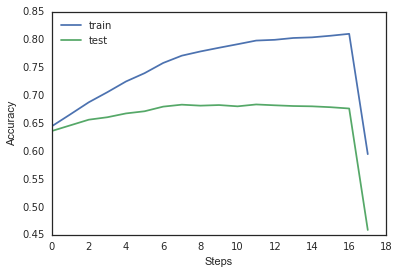

In [246]:
# plot our accuracies
plt.plot(xrange(len(train_scores)), train_scores, label='train')
plt.plot(xrange(len(test_scores)), test_scores, label='test')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend(loc=2);

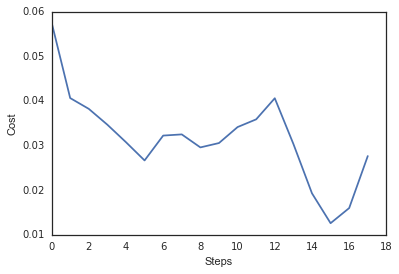

In [247]:
# plot our cost
plt.plot(xrange(len(costs)), costs)
plt.xlabel('Steps')
plt.ylabel('Cost');

**Conclusion:**
* Simple Feed-Forward gets us ~ 65% accuracy
* Adding convolution helps (maybe we should make this layer wider?)
* Adding Recurrancy (GRU) definitely helps
* After many, many hours trying to get CUDA up and running on my local computer, I found out It's not compatible ... 
* Training, not surprisingly, takes a long time
    * need to get AWS cluster up and running for training on GPU
        * found out I didn't have authorization to launch a cluster on AWS for some weird reason?
    * should have used Keris for batch normalization ... 
* Watch out for vanishing gradients!
    * ELU does a good job of quashing these!
* An adaptive learning rate would likely help
* TensorFlow looks so awesome

**Future Work**:
* Get this running on an AWS EC2 Cluster with GPUs
* Implement Batch Normalization with Keras
* Flip the proteins around, to instantly DOUBLE our dataset